# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [66]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


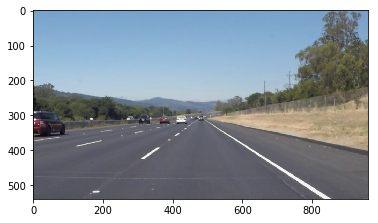

In [67]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  

`cv2.fillPoly()` for regions selection  

`cv2.line()` to draw lines on an image given endpoints  

`cv2.addWeighted()` to coadd / overlay two images

`cv2.cvtColor()` to grayscale or change color

`cv2.imwrite()` to output images to file  

`cv2.bitwise_and()` to apply a mask to an image


**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [68]:
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2


def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)


def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


def region_of_interest(img, vertices):
    """
    Applies an image mask.

    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    # defining a blank mask to start with
    mask = np.zeros_like(img)

    # defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    # filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    # returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=3):
    """
    NOTE: this is the function you might want to use as a starting point once you want to
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).

    Think about things like separating line segments by their
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of
    the lines and extrapolate to the top and bottom of the lane.

    This function draws `lines` with `color` and `thickness`.
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)


def draw_hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.

    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.

    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    return lines


# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.

    `initial_img` should be the image before any processing.

    The result image is computed as follows:

    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    
    return cv2.addWeighted(initial_img, α, img, β, λ)


# My Additions

def mask_colors(img):
    """
    `img` is the raw color image, this will mask all except yellow and white
    """
    # Mask all but white
    lower_white = np.array([200, 200, 200])
    upper_white = np.array([255, 255, 255])
    white_mask = cv2.inRange(img, lower_white, upper_white)
    
    # Mask all but yellow
    lower_yellow = np.array([130, 130, 0])
    upper_yellow = np.array([255, 255, 100])
    yellow_mask = cv2.inRange(img, lower_yellow, upper_yellow)
    
    # Combine the white and yellow mask
    mask = white_mask + yellow_mask

    return mask

def separate_left_right_lines(img, lines):
    """
    `img` The original image, to get dimensions from
    `lines` Just the Hough Line points
    This function looks at the slope of the lines and the location on screen,
    those with a negative slope and on the left half are left lane line segments
    and vice versa.
    """
    imshape = img.shape
    imwidth = imshape[1]
    imheight = imshape[0]
    
    left_lane_points = []
    right_lane_points = []
    
    for line in lines:
        
        for x1, y1, x2, y2 in line:
            
            m = ((y2 - y1) / (x2 - x1))
            
            # Left half of image and negative slope => left lane
            if m < 0 and x1 < imwidth*0.5 and x2 < imwidth*0.5:
                left_lane_points.append([x1, y1])
                left_lane_points.append([x2, y2])

            # Right half of image and positive slope => right lane
            if m > 0 and x1 > imwidth*0.5 and x2 > imwidth*0.5:
                right_lane_points.append([x1, y1])
                right_lane_points.append([x2, y2])
    
    return np.array(left_lane_points), np.array(right_lane_points)
    

def extrapolate_line(img, points):
    """
    `img` original image to get dimensions
    `points` a set of points eg: [[x1, y1], [x2, y2], ...]
    This function takes a set of points and run least squares to get a best fit
    estimate of the lane line. Using polyfit with degree 1
    """
    
    imshape = img.shape
    imwidth = imshape[1]
    imheight = imshape[0]
    
    if not len(points):
        return
        
    fit = np.polyfit(points[:, 0], points[:, 1], 1)
            
    # Fitted parameters to y = m*x + b
    m, b = fit
    
    # We know the y-coords, we need to calculate x based on the y-bottom and y-top of the region
    # Solving y = m*x + b for x: x = (y - b)/m, y-top = region's top boundary, y-bottom is image height
    lane_start = (int((imheight - b)/m), imheight)
    lane_end = (int(((imheight * region_top_multi) - b)/m), int(imheight * region_top_multi))
    
    cv2.line(img, lane_start, lane_end, (255, 0, 0), 12)
    
    
def extend_lane_lines(image, lines):
    """
    `image` original image for drawing the overlay
    `lines` Hough line output (just the line points)
    """
    
    # Create a blank overlay image
    overlay_image = np.copy(image) * 0
    
    # Get a set of points that represent the left and right lanes
    left_lane_points, right_lane_points = separate_left_right_lines(image, lines)
    
    # Extrapolate each
    extrapolate_line(overlay_image, left_lane_points)
    extrapolate_line(overlay_image, right_lane_points)
    
    return weighted_img(overlay_image, image)


## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [69]:
import os
test_images = os.listdir("test_images/")

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

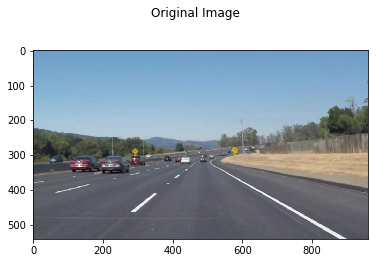

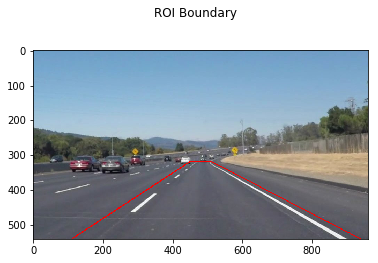

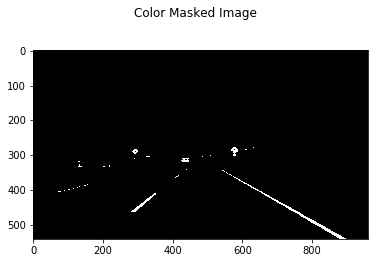

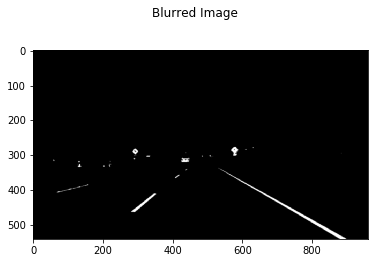

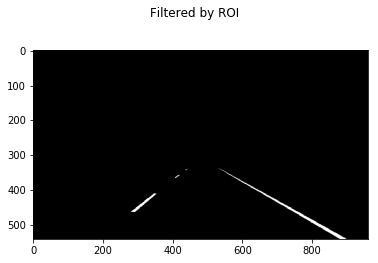

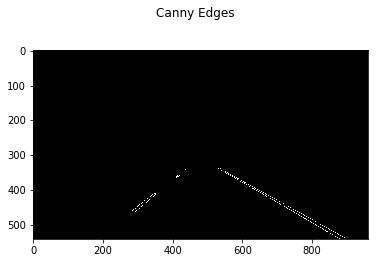

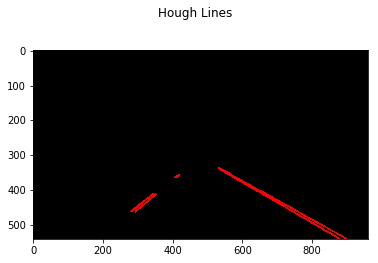

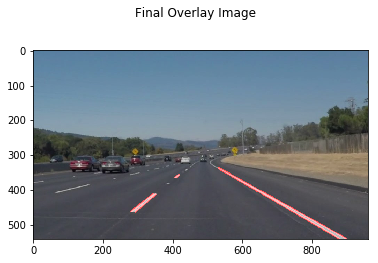

In [132]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

# The ROI's top boundary from the top of the image
region_top_multi = 0.59
# ROI's width of top segment
region_top_width = 60

hough_line_threshold = 15
min_line_length = 8
max_line_gap = 5
canny_min = 30
canny_max = 130


# Set to true to show all stages of the pipeline
DEBUG = True


def preprocess(image):
    imshape = image.shape
    imwidth = imshape[1]
    imheight = imshape[0]
    
    # Mask all except yellow and white
    masked = mask_colors(image)
    
    # Blur the input image
    blurred = gaussian_blur(masked, 5)

    # Create the region of interest about half way down the image and slightly inset from the sides
    top_left = (int(imwidth * 0.5) - int(region_top_width/2), int(imheight * region_top_multi))
    top_right = (int(imwidth * 0.5 + int(region_top_width/2)), int(imheight * region_top_multi))
    bottom_left = (110, imheight)
    bottom_right = (imwidth - 20, imheight)
    roi_boundary = np.array([[top_left, top_right, bottom_right, bottom_left]], dtype=np.int32)

    # Draw the region boundary on a copy of the original image
    region_image = np.copy(image)
    cv2.polylines(region_image, [roi_boundary], True, (255, 0, 0), 2)
    
    # Filter out all except the ROI
    roi = region_of_interest(blurred, roi_boundary)
    
    # Run Canny edge detection
    edges = canny(roi, canny_min, canny_max)
    
    if DEBUG:
        fig = plt.figure()
        fig.suptitle('Original Image')
        plt.imshow(image)

        fig = plt.figure()
        fig.suptitle('ROI Boundary')
        plt.imshow(region_image)

        fig = plt.figure()
        fig.suptitle('Color Masked Image')
        plt.imshow(masked, cmap='gray')
        
        fig = plt.figure()
        fig.suptitle('Blurred Image')
        plt.imshow(blurred, cmap='gray')
        
        fig = plt.figure()
        fig.suptitle('Filtered by ROI')
        plt.imshow(roi, cmap='gray')
        
        fig = plt.figure()
        fig.suptitle('Canny Edges')
        plt.imshow(edges, cmap='gray')

        plt.show()
        
    return edges
        

def run_pipeline_part1(image):
    edges = preprocess(image)
    
    # Draw lines Hough Lines
    hough_image = np.copy(edges)
    lines_image = draw_hough_lines(hough_image, 1, np.pi / 180, 
                                   hough_line_threshold, min_line_length, max_line_gap)
    
    # Overlay the Hough lines on the original image
    output = weighted_img(lines_image, image)    

    if DEBUG:
        fig = plt.figure()
        fig.suptitle('Hough Lines')
        plt.imshow(lines_image)
        
        fig = plt.figure()
        fig.suptitle('Final Overlay Image')
        plt.imshow(output)
        
        plt.show()
        
    return output


def run_pipeline_part2(image):
    edges = preprocess(image)
    
    # Just get the Hough Line points
    lines = hough_lines(edges, 1, np.pi / 180, 
                        hough_line_threshold, min_line_length, max_line_gap)
    
    # Extrapolate the lane lines
    output = extend_lane_lines(image, lines)

    if DEBUG:
        fig = plt.figure()
        fig.suptitle('Final Overlay Image')
        plt.imshow(output)
        
        plt.show()
        
    return output


def run_test_images():

    for filename in test_images:
        if not filename.endswith('.jpg'):
            continue
            
        image = mpimg.imread('test_images/{}'.format(filename))

        result_p1 = run_pipeline_part1(image)
        cv2.imwrite('test_images_output_p1/{}'.format(filename), cv2.cvtColor(result_p1, cv2.COLOR_RGB2BGR))
        
        plt.figure()
        plt.imshow(result_p1)

        result_p2 = run_pipeline_part2(image)        
        cv2.imwrite('test_images_output_p2/{}'.format(filename), cv2.cvtColor(result_p2, cv2.COLOR_RGB2BGR))
        
        plt.figure()
        plt.imshow(result_p2)
        
        
def test_one_image():
    # Set debug to True above
    image = mpimg.imread('test_images/solidWhiteCurve.jpg')
    run_pipeline_part1(image)        
    

test_one_image()
    
# run_test_images()


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [113]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [114]:
def process_part1(image):
    return run_pipeline_part1(image)

def process_part2(image):
    return run_pipeline_part2(image)

Let's try the one with the solid white lane on the right first ...

In [115]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,2)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_part2) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:13<00:00, 17.36it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 2.71 s, sys: 180 ms, total: 2.89 s
Wall time: 14.6 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [116]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [117]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_part2)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:36<00:00, 18.71it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 6.79 s, sys: 370 ms, total: 7.16 s
Wall time: 37.8 s


In [118]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [119]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(5,7)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_part2)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:26<00:00,  8.20it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 3.93 s, sys: 350 ms, total: 4.28 s
Wall time: 29.3 s


In [120]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

[//]: # (Image References)

[test_original]: ./test_run/original.png "Original Image"
[test_roi_boundary]: ./test_run/roi_boundary.png "ROI Boundary"
[test_color_masked]: ./test_run/color_masked.png "Color Masked for Yellow and White"
[test_blurred]: ./test_run/blurred.png "Blurred Image"
[test_roi_masked]: ./test_run/roi_masked.png "Masked to Region of Interest"
[test_canny]: ./test_run/canny_edge.png "Canny Edges"
[test_hough]: ./test_run/hough_lines.png "Hough Lines Overlay"
[test_final]: ./test_run/final.png "Final Lane Overlay"


## Finding Lane Lines on the Road


### 1. Overview

My pipeline is broken into two parts, the first is a preprocessing step that does the following:

** 1. Preprocessing Step**
1. Mask all colors except white and yellow
1. Apply a Gaussian blur to the masked image
1. Mask all except that within the region of interest
1. Run Canny edge detection on the ROI
1. Return the edges


** 2. Estimation Step**
1. Runs Hough lines on the Canny edge output
1. Separates the left from right lane line segments
1. Polyfits each set of points for the left and right lanes
1. Draws extended lane lines from top to bottom of the region

For debugging and testing, I have a function that just takes output of Canny edge detection step and draws the Hough lines onto the original image, showing outlines where lanes are detected.

I created a few extra functions that handle the Hough lines output, separate the left from right lanes, run polyfit and draw the extended lines.

**Samples of the pipeline on a test image:**

![alt text][test_original]
![alt text][test_roi_boundary]
![alt text][test_color_masked]
![alt text][test_blurred]
![alt text][test_roi_masked]
![alt text][test_canny]
![alt text][test_hough]
![alt text][test_final]

The test image outputs for drawing Hough lines are here: `./test_images_output_p1`. 

The final extended line outputs are here: `./test_images_output_p2`.

Here are the final video outputs: `./test_videos_output`



### 2. Assumptions

- When separating the left from right lanes, the slope of the line was not enough to filter the line segments. I added a crude check for lines on the left and right half of the image frame, but this could cause issues with curved roads where the left or right lane curves into the opposite half of the image.

- The frame size and position of the camera are fixed so the region of interest could
be hard coded, assuming that the horizon is static in all videos. When testing on the 
curved road video, I had to adjust the region boundaries to accomodate. This would also be an issue when approaching a downhill or uphill section of road.

- All videos/images are from daytime driving. Adjustments to the Canny edge and Hough
 lines would be needed for different times of days. Or if the sun.


### 3. Possible Improvements

- For curved roads a high order polynomial fit would improve the lane line estimates, but
could lead to more error in the estimate for very windy roads.

- Mounting the camera higher might help capture more lane lines in the distance, which
would improve estimation of the full lane.

- More averaging could smooth out the lane line estimates, currently the line extension jitters which could create issues downstream during processing where a controller might overreact to fast changes in lane position.